Model: "SizeModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x_size (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_size (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_sizes        │ (None, 2)         │          0 │ x_size[0][0],     │
│ (Concatenate)       │                   │            │ y_size[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_16 (Dense)   │ (None, 16)        │         48 │ concat_sizes[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_8 (Dense)    │ (None, 8)         │        136 │ hidden_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │          9 │ hidden_8[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.5143 - loss: 0.6922 - val_accuracy: 0.6211 - val_loss: 0.6887
Epoch 2/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5679 - loss: 0.6894 - val_accuracy: 0.6267 - val_loss: 0.6876
Epoch 3/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5852 - loss: 0.6894 - val_accuracy: 0.6266 - val_loss: 0.6868
Epoch 4/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5922 - loss: 0.6891 - val_accuracy: 0.6604 - val_loss: 0.6861
Epoch 5/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5737 - loss: 0.6886 - val_accuracy: 0.6606 - val_loss: 0.6853
Epoch 6/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5692 - loss: 0.6883 - val_accuracy: 0.6606 - val_loss: 0.6845
Epoch 7/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5623 - loss: 0.6878 - val_accuracy: 0.6608 - val_loss: 0.6838
Epoch 8/120
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5608 - loss: 0.6874 - val_accuracy: 0

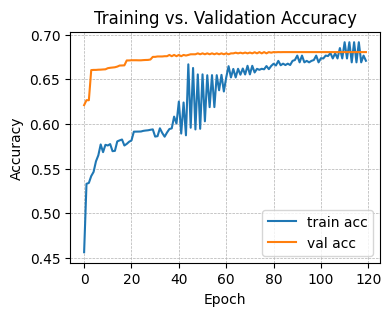

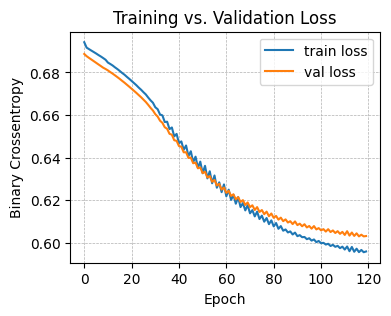

In [ ]:
import OptimizedDataGenerator4 as ODG
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pathlib import Path
from config import BASE_DIR, TRAIN_DIR, VALIDATION_DIR

# 1) Build the x_size + y_size model:
def CreateSizeModel():
    # two scalar inputs
    x_size = tf.keras.Input(shape=(1,), name="x_size")
    y_size = tf.keras.Input(shape=(1,), name="y_size")
    
    # concatenate into a 2-vector
    concat = tf.keras.layers.Concatenate(name="concat_sizes")([x_size, y_size])
    
    # hidden layers
    h1 = tf.keras.layers.Dense(16, activation="relu", name="hidden_16")(concat)
    h2 = tf.keras.layers.Dense(8, activation="relu", name="hidden_8")(h1)
    
    # output layer for binary classification
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(h2)
    
    model = tf.keras.Model(inputs=[x_size, y_size], outputs=output, name="SizeModel")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# instantiate and view summary
model = CreateSizeModel()
model.summary()

# 2) Set up data generators
base_dir       = BASE_DIR
train_dir      = TRAIN_DIR
validation_dir = VALIDATION_DIR

train_gen = ODG.OptimizedDataGenerator(
    load_records         = True,
    tf_records_dir       = str(train_dir),
    x_feature_description = ["x_size", "y_size"]
)
val_gen = ODG.OptimizedDataGenerator(
    load_records         = True,
    tf_records_dir       = str(validation_dir),
    x_feature_description = ["x_size", "y_size"]
)

# 3) Early stopping callback
es = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# 4) Train
history = model.fit(
    x               = train_gen,
    validation_data = val_gen,
    epochs          = 120,
    callbacks       = [es],
    shuffle         = False,
    verbose         = 1
)

# 5) Plot training history
plt.figure(figsize=(4,3))
plt.plot(history.history["accuracy"],    label="train acc")
plt.plot(history.history["val_accuracy"],label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(linestyle="--", linewidth=0.5)
plt.title("Training vs. Validation Accuracy")
plt.show()

plt.figure(figsize=(4,3))
plt.plot(history.history["loss"],    label="train loss")
plt.plot(history.history["val_loss"],label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(linestyle="--", linewidth=0.5)
plt.title("Training vs. Validation Loss")
plt.show()
